# Sentiment analysis using Machine Learning Algorithms

In [ ]:
# !python -m spacy download en_core_web_sm

In [9]:
import joblib
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import spacy
nlp = spacy.load('en_core_web_sm')

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Load and preprocess the data

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
df = pd.read_csv(
    '/content/drive/MyDrive/convo_insight_project/train.csv',
    names=['class_index', 'review_title', 'review_text'])
print(df.shape)
df['class_index'] = df['class_index'].map(
    {
        1: -1,
        2: -1,
        3: 0,
        4: 1,
        5: 1,
    })
df.to_csv('amazon_reviews_sentiment_3cls_train.csv', index=False)

(3000000, 3)


In [38]:
df.head()

,class_index,review_title,review_text
0,0,more like funchuck,Gave this to my dad for a gag gift after direc...
1,1,Inspiring,I hope a lot of people hear this cd. We need m...
2,1,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,1,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,1,Too good to be true,Probably the greatest soundtrack in history! U...


In [15]:
def get_custom_stopwords():
    nltk_stop_words = set(stopwords.words('english'))
    spacy_stop_words = nlp.Defaults.stop_words

    negation_words = {
        'no', 'not', 'nor', 'neither', 'never', 'none',
        "n't", 'cannot', "couldn't", "didn't", "doesn't",
        "hadn't", "hasn't", "haven't", "isn't", "mightn't",
        "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
        "weren't", "won't", "wouldn't"
    }

    combined_stopwords = nltk_stop_words.union(spacy_stop_words)
    custom_stopwords = combined_stopwords - negation_words
    return custom_stopwords


custom_stopwords = get_custom_stopwords()
print(custom_stopwords)

{'keep', '’ll', 'whenever', 'first', 'hasn', 'hereupon', 'being', 'due', 'be', 'eight', 'yet', 'his', "she's", 'full', 'thereafter', 'in', 'mustn', 'once', 'whatever', 'isn', "you'll", 'perhaps', 'top', 'where', 'seeming', 'move', 'other', 'used', 'which', 'take', 'theirs', 'ten', 'having', 're', 'y', 'could', 'beyond', 'anything', 'regarding', 'wouldn', 'another', 'latter', 'so', 'others', 'onto', 'third', 'whoever', 'at', 'thus', '’m', 'off', 'have', 'amount', 'we', "don't", 'enough', '‘ll', 'these', 'say', "'s", 'become', 's', 'ever', 'been', 'hundred', 'below', 'moreover', 'see', 'just', 'all', 'i', 'thereupon', 'ours', 'every', 'or', 'must', 'into', 'either', 'around', 'next', 'doesn', 'former', 'll', 'somewhere', 'anywhere', 'get', 'from', 'already', 'may', 'ain', 'the', 'sometime', 'she', 'than', 'whence', 'several', 'then', 'though', 'beside', 'throughout', 'four', 'one', "'ve", 'doing', 'this', 'because', 'someone', 'everyone', 'still', 'her', 'indeed', 'less', 'our', 'as', 'w

In [ ]:
def load_data(file_path):
    data = pd.read_csv(file_path, usecols=range(3))
    return data


def preprocess_text(text):
    # Tokenize
    tokens = word_tokenize(text.lower())

    # Remove stopwords and non-alphabetic tokens
    tokens = [token for token in tokens if token.isalpha()
              and token not in custom_stopwords]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


# Load the data
# data = load_data('amazon_reviews_sentiment_3cls.csv')

# Preprocess the text
df['processed_text'] = df['review_text'].apply(preprocess_text)

In [17]:
df.head()

,class_index,review_title,review_text,processed_text
0,-1,mens ultrasheer,"This model may be ok for sedentary types, but ...","[model, ok, sedentary, type, active, alot, job..."
1,1,Surprisingly delightful,This is a fast read filled with unexpected hum...,"[fast, read, filled, unexpected, humour, profo..."
2,-1,"Works, but not as advertised",I bought one of these chargers..the instructio...,"[bought, charger, instruction, light, stay, ba..."
3,-1,Oh dear,I was excited to find a book ostensibly about ...,"[excited, find, book, ostensibly, muslim, femi..."
4,-1,Incorrect disc!,"I am a big JVC fan, but I do not like this mod...","[big, jvc, fan, not, like, model, suspiscious,..."


In [18]:
df['review_text'].iloc[1:5].values

array(['This is a fast read filled with unexpected humour and profound insights into the art of politics and policy. In brief, it is sly, wry, and wise.',
       'I bought one of these chargers..the instructions say the lights stay on while the battery charges...true. The instructions doNT say the lights turn off when its done. Which is also true. 24 hours of charging and the lights stay on. I returned it thinking I had a bad unit.The new one did the same thing. I just kept it since it does charge...but the lights are useless since they seem to always stay on. It\'s a "backup" charger for when I manage to drain all my AAs but I wouldn\'t want this as my only charger.',
       'I was excited to find a book ostensibly about Muslim feminism, but this volume did not live up to the expectations.One essay, among other things, describes the veil as potentially liberating. It doesn\'t begin to explain how or why.Another, on Muslim women in Cape Town, claims that Muslim women there are separate

In [19]:
df['processed_text'].iloc[1:5].values

array([list(['fast', 'read', 'filled', 'unexpected', 'humour', 'profound', 'insight', 'art', 'politics', 'policy', 'brief', 'sly', 'wry', 'wise']),
       list(['bought', 'charger', 'instruction', 'light', 'stay', 'battery', 'charge', 'true', 'instruction', 'dont', 'light', 'turn', 'true', 'hour', 'charging', 'light', 'stay', 'returned', 'thinking', 'bad', 'new', 'thing', 'kept', 'charge', 'light', 'useless', 'stay', 'backup', 'charger', 'manage', 'drain', 'aa', 'want', 'charger']),
       list(['excited', 'find', 'book', 'ostensibly', 'muslim', 'feminism', 'volume', 'not', 'live', 'essay', 'thing', 'describes', 'veil', 'potentially', 'liberating', 'begin', 'explain', 'muslim', 'woman', 'cape', 'town', 'claim', 'muslim', 'woman', 'separate', 'equal', 'gee', 'whiz', 'expected', 'hoped', 'muslim', 'feminist', 'condemnation', 'gender', 'apartheid', 'not', 'single', 'surprised', 'essay', 'extolling', 'virtue', 'female', 'genital', 'alyssa', 'lappen']),
       list(['big', 'jvc', 'fan', 'no

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650000 entries, 0 to 649999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   class_index     650000 non-null  int64 
 1   review_title    649974 non-null  object
 2   review_text     650000 non-null  object
 3   processed_text  650000 non-null  object
dtypes: int64(1), object(3)
memory usage: 19.8+ MB


###  Create Word2Vec embeddings

In [21]:
def create_word2vec_model(sentences, vector_size=100, window=5, min_count=1, workers=16):
    model = Word2Vec(sentences=sentences, vector_size=vector_size,
                     window=window, min_count=min_count, workers=workers)
    return model


# Train Word2Vec model
word2vec_model = create_word2vec_model(df['processed_text'])

### Save the word2vec model

In [23]:
# Save the Word2Vec model
joblib.dump(word2vec_model, 'word2vec_model_train.joblib')
# To load the models later
# load_word2vec_model = joblib.load('word2vec_model.joblib')

### Function to get document embedding

In [24]:
def get_document_embedding(tokens, model, vector_size=100):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

In [25]:
# Create document embeddings
df['embedding'] = df['processed_text'].apply(
    lambda x: get_document_embedding(x, load_word2vec_model))

In [ ]:
# data.to_csv('amazon_reviews_sentiment_3cls.csv', index=False)

In [26]:
df['embedding'].iloc[1:5].values

array([array([-0.79083204, -0.16079982,  0.8503095 ,  0.9431798 ,  0.46446183,
               0.04415749,  0.27979428, -0.23315026, -0.41617817,  0.59459966,
               1.2690722 , -0.48841006,  0.45169163,  1.1946257 , -0.51594627,
               0.4545781 , -0.24694817, -0.11361344,  0.4420838 , -0.6689757 ,
              -0.2262592 , -0.47083396,  1.0640008 ,  0.15762918, -0.01821958,
              -0.18888041, -0.3496144 , -0.12901269, -0.3566137 , -1.1046326 ,
               0.24097395, -0.40102568, -0.2281956 ,  0.32754588,  0.3715599 ,
              -0.08186986, -0.8356589 , -0.3580797 , -0.30001268, -0.7002834 ,
              -0.25014076,  0.5947295 ,  0.07511606,  0.21238956,  0.3045017 ,
               0.7998501 ,  0.82154375,  0.01624027,  0.2722824 ,  0.8490218 ,
               0.14637884, -0.73301065, -0.8060573 , -0.47543183, -1.2604166 ,
              -0.47361955,  0.768335  ,  0.5512877 , -0.2153904 , -1.3145295 ,
               0.09310602,  0.56736124, -0.44073153,

### Prepare the data for training

In [27]:
X = np.array(df['embedding'].tolist())
y = df['class_index']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
del df

### Train a Random Forest classifier

In [29]:
clf = RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42)

### Save the classifier

In [30]:
# Save the classifier
joblib.dump(clf, 'classifier_model_train.joblib')

# To load the classifier later
# load_clf = joblib.load('classifier_model.joblib')
# load_word2vec_model = joblib.load('word2vec_model.joblib')

['classifier_model.joblib']

### Evaluate the model

In [31]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.80      0.71     51873
           0       0.43      0.04      0.07     26226
           1       0.65      0.80      0.72     51901

    accuracy                           0.64    130000
   macro avg       0.58      0.54      0.50    130000
weighted avg       0.60      0.64      0.58    130000



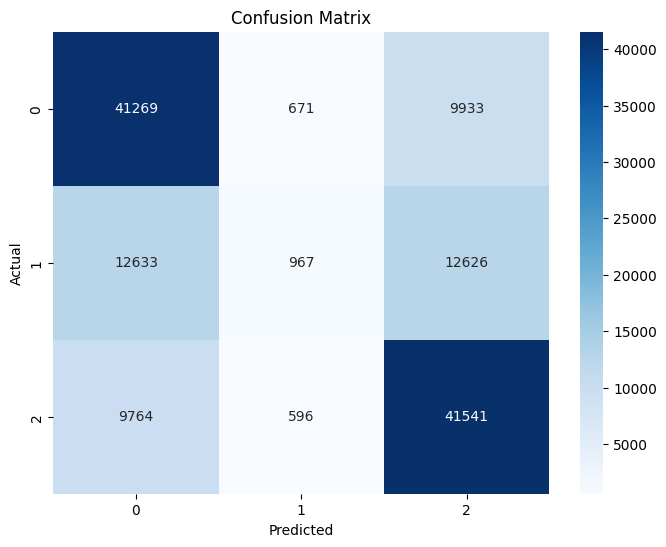

In [32]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Create a function for sentiment prediction

In [33]:
def predict_sentiment(text, word2vec_model, clf):
    processed_text = preprocess_text(text)
    embedding = get_document_embedding(processed_text, word2vec_model)
    prediction = clf.predict([embedding])[0]
    return prediction


# Example usage
load_clf = joblib.load('classifier_model_train.joblib')
load_word2vec_model = joblib.load('word2vec_model_train.joblib')

Sentiment: 1


In [36]:
sample_text = "ok"
result = predict_sentiment(sample_text, load_word2vec_model, load_clf)
print(f"Sentiment: {result}")

Sentiment: 0


## Complete Code

In [ ]:
import joblib
import nltk
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import spacy

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load spacy model
nlp = spacy.load('en_core_web_sm')


def get_custom_stopwords():
    """Get custom stopwords excluding negation words"""
    nltk_stop_words = set(stopwords.words('english'))
    spacy_stop_words = nlp.Defaults.stop_words

    negation_words = {
        'no', 'not', 'nor', 'neither', 'never', 'none',
        "n't", 'cannot', "couldn't", "didn't", "doesn't",
        "hadn't", "hasn't", "haven't", "isn't", "mightn't",
        "mustn't", "needn't", "shan't", "shouldn't", "wasn't",
        "weren't", "won't", "wouldn't"
    }

    combined_stopwords = nltk_stop_words.union(spacy_stop_words)
    return combined_stopwords - negation_words


custom_stopwords = get_custom_stopwords()


def preprocess_text(text):
    """Preprocess text with basic cleaning and lemmatization"""
    # Convert to lowercase and tokenize
    tokens = word_tokenize(str(text).lower())

    # Remove stopwords, non-alphabetic tokens and short words
    tokens = [token for token in tokens if token.isalpha()
              and token not in custom_stopwords
              and len(token) > 2]  # Filter very short words

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens


def create_word2vec_model(sentences, vector_size=50, window=5, min_count=5, workers=4):
    """Create Word2Vec model with optimized parameters"""
    model = Word2Vec(
        sentences=sentences,
        vector_size=vector_size,  # Reduced from 100 to 50
        window=window,
        min_count=min_count,  # Increased from 1 to 5 to reduce vocabulary
        workers=workers,
        max_vocab_size=10000  # Limit vocabulary size
    )
    return model


def get_document_embedding(tokens, model, vector_size=50):
    """Get document embedding by averaging word vectors"""
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)

    embeddings = [model.wv[word] for word in valid_tokens]
    return np.mean(embeddings, axis=0)


def train_sentiment_model(data_path):
    """Train the sentiment analysis model"""
    # Load and preprocess data
    df = pd.read_csv(data_path, names=[
                     'class_index', 'review_title', 'review_text'])

    # Map sentiment classes
    df['class_index'] = df['class_index'].map({
        1: -1,  # Negative
        2: -1,  # Negative
        3: 0,   # Neutral
        4: 1,   # Positive
        5: 1    # Positive
    })

    # Preprocess texts
    df['processed_text'] = df['review_text'].apply(preprocess_text)

    # Create and train Word2Vec model
    word2vec_model = create_word2vec_model(df['processed_text'])

    # Create document embeddings
    document_embeddings = np.array([
        get_document_embedding(tokens, word2vec_model)
        for tokens in df['processed_text']
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        document_embeddings,
        df['class_index'],
        test_size=0.2,
        random_state=42
    )

    # Train RandomForest with optimized parameters
    clf = RandomForestClassifier(
        n_estimators=100,      # Reduced from 150
        max_depth=10,          # Add max_depth to limit tree size
        min_samples_split=10,  # Increase min_samples_split
        min_samples_leaf=4,    # Increase min_samples_leaf
        max_features='sqrt',   # Use sqrt of features
        random_state=42,
        n_jobs=-1
    )

    clf.fit(X_train, y_train)

    # Evaluate
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Save models
    joblib.dump(word2vec_model, 'word2vec_model_optimized.joblib')
    joblib.dump(clf, 'classifier_model_optimized.joblib')

    return word2vec_model, clf


def predict_sentiment(text, word2vec_model, clf):
    """Predict sentiment for new text"""
    processed_text = preprocess_text(text)
    embedding = get_document_embedding(processed_text, word2vec_model)
    prediction = clf.predict([embedding])[0]
    return prediction


# Train models
word2vec_model, clf = train_sentiment_model(
    'amazon_reviews_sentiment_3cls_train.csv')

# Example prediction
sample_text = "This product is amazing! I love it."
result = predict_sentiment(sample_text, word2vec_model, clf)
print(f"Sentiment: {result}")

## With XGBoost Model

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create a label encoder to map {-1: 0, 0: 1, 1: 2}
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data with encoded labels
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

# Prepare the data for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set XGBoost parameters
params = {
    'objective': 'multi:softmax',  # multiclass classification
    'num_class': 3,  # three sentiment classes (0, 1, 2)
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # for faster training
    'eval_metric': 'mlogloss',
    'random_state': 42
}

# Train XGBoost model
num_rounds = 100
clf = xgb.train(
    params,
    dtrain,
    num_rounds,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=10,
    verbose_eval=10
)

# Save both the classifier and label encoder
joblib.dump({
    'classifier': clf,
    'label_encoder': label_encoder
}, 'xgboost_classifier_model_train.joblib')

# Predict and evaluate
y_pred = clf.predict(dtest)
# Convert predictions back to original labels for the classification report
y_test_original = label_encoder.inverse_transform(y_test)
y_pred_original = label_encoder.inverse_transform(y_pred.astype(int))
print(classification_report(y_test_original, y_pred_original))

# Update the prediction function to work with XGBoost and label encoding


def predict_sentiment(text, word2vec_model, models_dict):
    clf = models_dict['classifier']
    label_encoder = models_dict['label_encoder']

    processed_text = preprocess_text(text)
    embedding = get_document_embedding(processed_text, word2vec_model)
    dpredict = xgb.DMatrix(np.array([embedding]))
    prediction = clf.predict(dpredict)[0]
    # Convert prediction back to original label space (-1, 0, 1)
    original_prediction = label_encoder.inverse_transform([int(prediction)])[0]
    return original_prediction


# Example usage
models_dict = joblib.load('xgboost_classifier_model_train.joblib')
load_word2vec_model = joblib.load('word2vec_model_train.joblib')

sample_text = "ok"
result = predict_sentiment(sample_text, load_word2vec_model, models_dict)
print(f"Sentiment: {result}")